In [1]:
##### Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneOut, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from collections import Counter
from sklearn.model_selection import LeaveOneOut, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

In [2]:
#### Load full dataset

data_path = "train_file"
df = pd.read_csv(data_path)

X = df.iloc[:, :-1]
y = df["Label"]

print("Total samples:", X.shape[0])
print("Class distribution:", y.value_counts().to_dict())

Total samples: 18
Class distribution: {1: 12, 0: 6}


In [3]:
### Model definitions + parameter grids

models = {
    "SVM": SVC(probability=True),
    "RandomForest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "ExtraTrees": ExtraTreesClassifier()
}

param_grids = {
    "SVM": {
        "C": [0.01, 0.1, 1, 10, 100],
        "gamma": [1e-4, 1e-3, 1e-2, "scale"],
        "kernel": ["rbf", "linear"]
    },
    "RandomForest": {
        "n_estimators": [100, 300, 500],
        "max_depth": [None, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1.0]
    },
    "GradientBoosting": {
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1],
        "max_depth": [2, 3]
    },
    "ExtraTrees": {
        "n_estimators": [200, 500],
        "max_depth": [None, 5, 10],
        "min_samples_leaf": [1, 2]
    }
}

In [4]:
#### LOOCV with on-the-fly hyperparameter tuning

loo = LeaveOneOut()

all_results = {}
all_scores = {}
all_best_params = {}

for name, model in models.items():
    print(f"\n🔁 LOOCV + tuning for {name}")

    y_true_all = []
    y_score_all = []
    best_params_all = []

    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        inner_cv = StratifiedKFold(
            n_splits=min(3, y_train.value_counts().min()),
            shuffle=True,
            random_state=42
        )

        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grids[name],
            n_iter=10,
            scoring="roc_auc",
            cv=inner_cv,
            n_jobs=-1,
            random_state=42
        )

        search.fit(X_train, y_train)

        best_params_all.append(search.best_params_)
        best_model = search.best_estimator_

        if hasattr(best_model, "predict_proba"):
            score = best_model.predict_proba(X_test)[0, 1]
        else:
            score = best_model.decision_function(X_test)[0]

        y_true_all.append(y_test.values[0])
        y_score_all.append(score)

    # ---- convert to arrays ----
    y_true_all = np.array(y_true_all)
    y_score_all = np.array(y_score_all)

    # ---- THIS LINE IS CRITICAL FOR PLOTTING ----
    all_scores[name] = (y_true_all, y_score_all)

    # ---- metrics ----
    all_results[name] = {
        "LOOCV_AUROC": roc_auc_score(y_true_all, y_score_all),
        "LOOCV_AUPRC": average_precision_score(y_true_all, y_score_all)
    }

    # ---- consensus best params ----
    params_counter = Counter(tuple(sorted(p.items())) for p in best_params_all)
    consensus_params = dict(params_counter.most_common(1)[0][0])
    all_best_params[name] = consensus_params

    print("AUROC:", round(all_results[name]["LOOCV_AUROC"], 3))
    print("AUPRC:", round(all_results[name]["LOOCV_AUPRC"], 3))
    print("Best params:", consensus_params)


🔁 LOOCV + tuning for SVM
AUROC: 0.833
AUPRC: 0.935
Best params: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}

🔁 LOOCV + tuning for RandomForest
AUROC: 0.861
AUPRC: 0.936
Best params: {'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 500}

🔁 LOOCV + tuning for AdaBoost


/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
 

AUROC: 0.958
AUPRC: 0.972
Best params: {'learning_rate': 0.01, 'n_estimators': 50}

🔁 LOOCV + tuning for GradientBoosting


/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
 

AUROC: 0.917
AUPRC: 0.972
Best params: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}

🔁 LOOCV + tuning for ExtraTrees
AUROC: 0.889
AUPRC: 0.958
Best params: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 500}


In [15]:
#### Save the results

results_df = pd.DataFrame(all_results).T
results_df["Best_Params"] = results_df.index.map(lambda m: all_best_params[m])

out_path = ("LOOCV_nested_metrics_train.csv")
results_df.to_csv(out_path)

results_df

,LOOCV_AUROC,LOOCV_AUPRC,Best_Params
SVM,0.833333,0.938605,"{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}"
RandomForest,0.902778,0.956624,"{'max_depth': None, 'min_samples_leaf': 4, 'n_..."
AdaBoost,0.958333,0.972222,"{'learning_rate': 1.0, 'n_estimators': 50}"
GradientBoosting,0.916667,0.972222,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est..."
ExtraTrees,0.861111,0.943744,"{'max_depth': 10, 'min_samples_leaf': 2, 'n_es..."


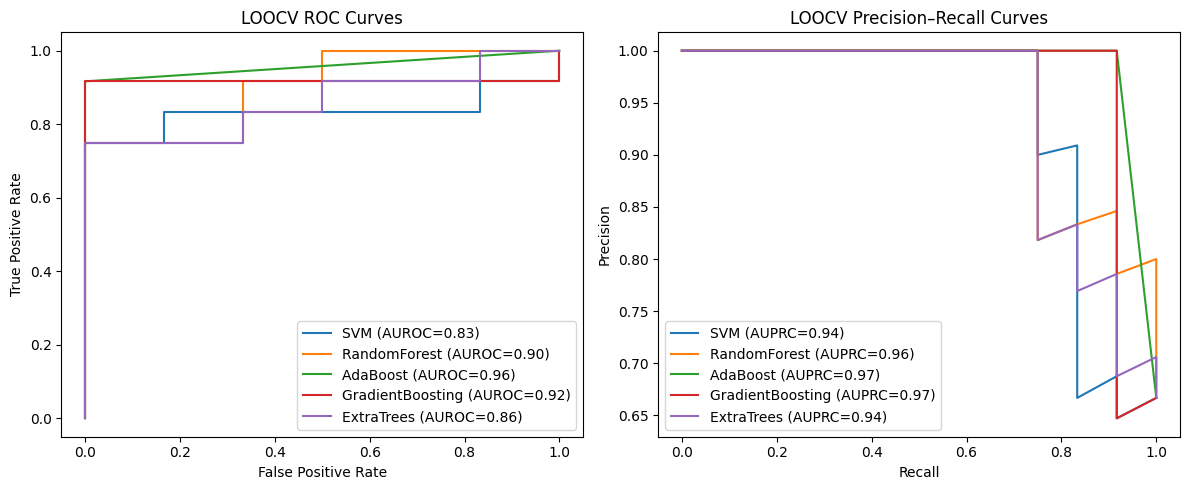

In [18]:
##### Plot AUROC and AUPRC

plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
plt.title("LOOCV ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# PR
plt.subplot(1, 2, 2)
plt.title("LOOCV Precision–Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")

for name, (y_true, y_score) in all_scores.items():
    fpr, tpr, _ = roc_curve(y_true, y_score)
    precision, recall, _ = precision_recall_curve(y_true, y_score)

    auroc = roc_auc_score(y_true, y_score)
    auprc = average_precision_score(y_true, y_score)

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"{name} (AUROC={auroc:.2f})")

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"{name} (AUPRC={auprc:.2f})")

plt.subplot(1, 2, 1)
plt.legend()
plt.subplot(1, 2, 2)
plt.legend()

plt.tight_layout()

plt.savefig(
    "/Users/piyushagrawal/Downloads/Chinmay/chancellor_work/"
    "analysis/machine_learning/result/LOOCV_nested_ROC_PR.png",
    dpi=600
)

plt.show()